In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix, recall_score, f1_score
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
%matplotlib inline


In [3]:
df_movie = pd.read_csv("data_movies_v3.csv")
df_movie.head()

,index,budget,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,...,History,Music,War,Documentary,Western,Foreign,TV Movie,num_of_production_companies,sentiment,subjective
0,0,237000000,Action Adventure Fantasy Science Fiction,19995,en,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,...,0,0,0,0,0,0,0,4,0.041667,0.616667
1,1,300000000,Adventure Fantasy Action,285,en,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,...,0,0,0,0,0,0,0,3,-0.083333,0.266667
2,2,245000000,Action Adventure Crime,206647,en,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,...,0,0,0,0,0,0,0,3,-0.306250,0.518750
3,3,250000000,Action Crime Drama Thriller,49026,en,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,...,0,0,0,0,0,0,0,4,-0.044805,0.372078
4,4,260000000,Action Adventure Science Fiction,49529,en,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,...,0,0,0,0,0,0,0,1,-0.016667,0.566667


In [4]:
df_for_model = df_movie[(df_movie[['budget','popularity','revenue', 'runtime','vote_average', 'vote_count', 'sentiment','subjective']] != 0).all(axis=1)]
df_for_model = df_for_model.loc[:, ['budget','popularity','revenue', 'runtime','vote_average', 'vote_count','Drama','Comedy', 'Thriller', 'Action', 'Romance', 'Adventure', 'Crime','Science Fiction', 'Horror', 'Family', 'Fantasy', 'Mystery','Animation', 'History', 'Music', 'War', 'Documentary', 'Western','Foreign', 'num_of_production_companies', 'sentiment','subjective']]


In [5]:
#Here we categorize popularity into three classes low, average and high represented by 0, 1 and 2

In [6]:
# Define the popularity categories
popularity_bins = [-1, 50, 100, float('inf')]
popularity_labels = [0, 1, 2]

# Convert the "popularity" column into categories
df_for_model['popularity'] = pd.cut(df_for_model['popularity'], bins=popularity_bins, labels=popularity_labels)

In [7]:
#Here we categorize movie into three classes hit, average and miss represented by 2, 1 and 0
pd.set_option('float_format', '{:f}'.format)
df_for_model['revenue'].describe()

count         2931.000000
mean     123144981.276015
std      187021342.284266
min              5.000000
25%       17289340.000000
50%       56702901.000000
75%      149484694.500000
max     2787965087.000000
Name: revenue, dtype: float64

In [8]:
# Define the conditions and assign values to "hit_average_miss"
df_for_model['hit_average_miss'] = 0  # Initialize with a default value
df_for_model.loc[df_for_model['revenue'] >= 2 * df_for_model['budget'], 'hit_average_miss'] = 2
df_for_model.loc[(df_for_model['budget'] <= df_for_model['revenue']) & (df_for_model['revenue'] < 2 * df_for_model['budget']), 'hit_average_miss'] = 1


In [9]:
df_for_model["revenue"].isna().sum()

0

Accuracy: 0.9011925042589438
Precision: 0.9037803927071388
Recall: 0.9011925042589438
F1 Score: 0.9021027558283271


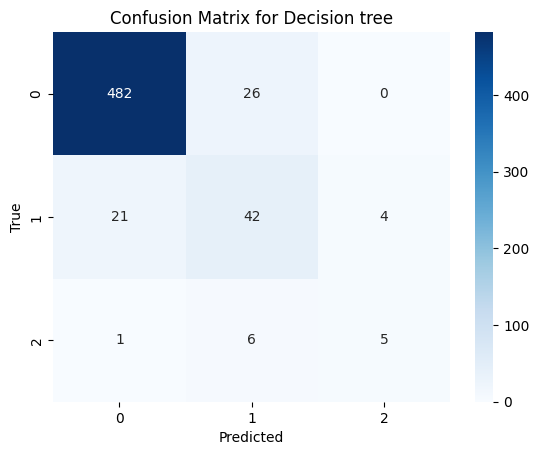

In [20]:
#Sanity Check
X= df_for_model.drop(['popularity','revenue','hit_average_miss'], axis=1)
y = df_for_model['popularity']
select = SelectKBest(f_classif, k=11)
X = select.fit_transform(X, y)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# Optional: Scale input features
parameters = {'max_depth':[2,60], 'min_samples_split':[2, 100]}
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create and train a Decision Tree Classifier model
model = tree.DecisionTreeClassifier()
grid = GridSearchCV(model, parameters)
grid.fit(X_train, y_train)
# Make predictions
y_pred = grid.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix for Decision tree")
plt.show()

In [21]:
grid.best_params_

{'max_depth': 2, 'min_samples_split': 2}

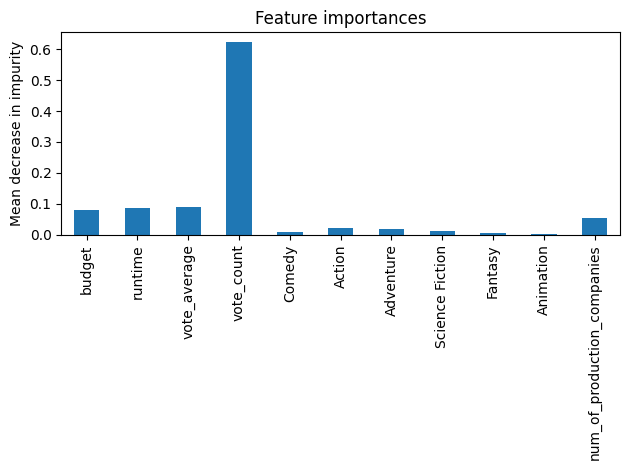

In [22]:
model.fit(X_train, y_train)
importance = model.feature_importances_
feature_names = select.get_feature_names_out()
tree_importances = pd.Series(importance, index=feature_names)
fig, ax = plt.subplots()
tree_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Mean Squared Error: 8478870822895647.0
Square root of Mean Squared Error: 92080784.22176717
R-squared value: 0.7788095801696888


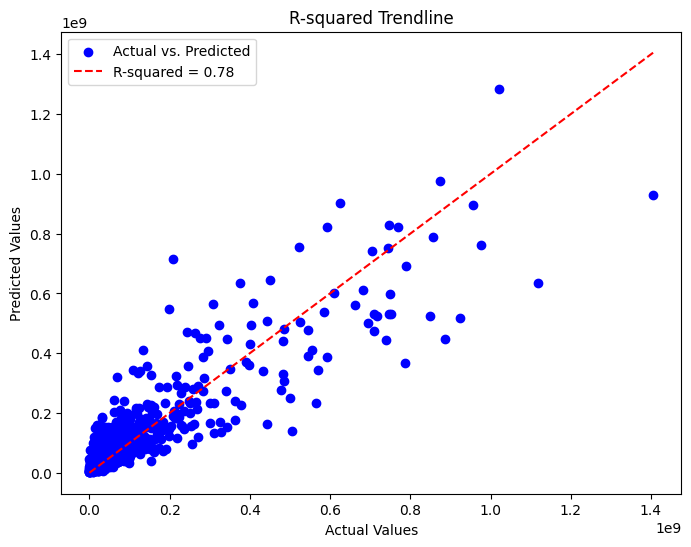

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

#Sanity Check
X= df_for_model.drop(['popularity','revenue','hit_average_miss'], axis=1)
y = df_for_model['revenue']

select = SelectKBest(f_classif, k=11)
X = select.fit_transform(X, y)
parameters = {'max_depth':[2,60], 'min_samples_split':[2, 100], 'n_estimators':[1,400]}
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Optional: Scale input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create and train a Decision Tree Classifier model

model = RandomForestRegressor()
grid = GridSearchCV(model, parameters)
grid.fit(X_train, y_train)

# Make predictions
y_pred = grid.predict(X_test)

# Evaluate the model
r_squared = grid.score(X_test, y_test)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Square root of Mean Squared Error:", np.sqrt(mse))
print("R-squared value:", r_squared)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Actual vs. Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label=f'R-squared = {r_squared:.2f}')
plt.legend()
plt.title('R-squared Trendline')
plt.show()


In [13]:
grid.best_params_

{'max_depth': 60, 'min_samples_split': 2, 'n_estimators': 400}

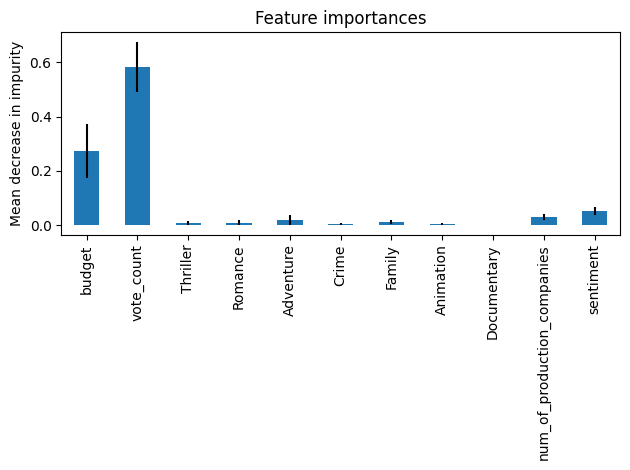

In [14]:
forest = RandomForestRegressor(max_depth= 60, min_samples_split = 2, n_estimators= 400)
forest.fit(X_train, y_train)
importance = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
feature_names = select.get_feature_names_out()
tree_importances = pd.Series(importance, index=feature_names)
fig, ax = plt.subplots()
tree_importances.plot.bar(yerr = std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()